# Elastic Net

#### Import data and packages

In [1]:
# Import packages
import os
import pandas as pd
import numpy as np

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression as lin
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

import warnings
from matplotlib import pyplot as plt

In [2]:
# Your directory
os.chdir("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis")

# Define periodic prediction function
def periods_lags(df, y_variable, n_periods, n_lags, frequency):
    # Copy input data
    df_copy = df.copy()
    y = df_copy.loc[:, y_variable]
    name_ = y.name
    y_out = pd.DataFrame()
    
    # Drop y-variable from dataframe
    df_copy.drop(columns = [y_variable], inplace = True)
    
    # Create periodic y-variables
    for period in range(n_periods + 1):
        name = name_ + "_q_" + str(period)
        add_period = y.pct_change(period + 1)
        add_period = add_period.shift(-period)
        y_out = pd.concat([y_out, add_period.rename(name)], axis = 1)
    
    # Create lags of y-variables
    for lag in range(1, n_lags + 1):
        name = name_ + "_for_pred_lag_" + str(lag)
        add_lag = y.pct_change().replace(np.nan, 0)
        add_lag.drop(index = add_lag.index[0], inplace = True)
        add_lag = add_lag.shift(lag)
        df_copy[name] = add_lag
        
    # Make sure X and y are of equal index
    y_out.replace(to_replace = np.nan, value = 0, inplace = True)
    index = list(set(df_copy.dropna().index) & set(y_out.index))
    X = df_copy.loc[index, :]
    y = y_out.loc[index, :]
    X.sort_index(inplace = True)
    y.sort_index(inplace = True)
    
    return X, y

# User inputs
n_periods = 4
n_lags = 1
frequency = 1

# Import data and publication dates
df = pd.read_excel("Data/master_thesis_data.xlsx", index_col = 0)

# Extract NO_folio_publication_date
pub_dates = df.NO_folio_publication_date

df, folio_rate = periods_lags(df, "NO_folio_publication_date", n_periods, n_lags, frequency)
folio_rate.rename(columns = {"NO_folio_publication_date":"NO_folio_rate"}, inplace = True)
                
print("Data succesfully imported. Shape of X = {}, y = {}".format(df.shape, folio_rate.shape))

Data succesfully imported. Shape of X = (159, 687), y = (159, 5)


In [3]:
# Train-test split
X_train, X_test, y_train, y_test = tts(df, folio_rate, test_size = 0.2, shuffle = False, random_state = None)

# === Standardization ===
# Extract indeces and columns from data
X_train_index = X_train.index
X_test_index = X_test.index
X_columns = X_train.columns

# Transform back to dataframes
X_train = pd.DataFrame(X_train, index = X_train_index, columns = X_columns)
X_test = pd.DataFrame(X_test, index = X_test_index, columns = X_columns)

print("X train: {}".format(X_train.shape))
print("X test: {}".format(X_test.shape))
print("y train: {}".format(y_train.shape))
print("y test: {}".format(y_test.shape))

X train: (127, 687)
X test: (32, 687)
y train: (127, 5)
y test: (32, 5)


#### Model construction

In [4]:
def tscv_multi(n_splits, X_train, y_train, X_test, y_test):
    warnings.filterwarnings('ignore')

    # Define alphas and lambdas for grid search
    alphas = np.arange(0, 1, 0.1)
    lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

    # Cross validations
    tscv = TimeSeriesSplit(n_splits = n_splits, test_size = None)

    # Construct model with k-fold cross validation for comparison
    model_tscv = ElasticNetCV(l1_ratio = alphas,
                            alphas = lambdas,
                            cv = tscv,
                            n_jobs = -1,
                            verbose = 0
                            )

    # Fit the models
    models = dict()
    alphas = list()
    lambdas = list()
    mse_paths = list()
    is_predictions = pd.DataFrame()
    oos_predictions = pd.DataFrame()
    mse_s = dict()
    coefs = dict()
    for period in range(y_train.shape[1]):
        model = model_tscv
        
        # Remove nans for y-variables and slice X
        y_train_, y_test_ = y_train.iloc[:, period].dropna(), y_test.iloc[:, period].dropna()
        train_index, test_index = y_train_.index, y_test_.index
        X_test_ = X_test.loc[test_index, :]
        X_train_ = X_train.loc[train_index, :]
        
        # Fit model
        model.fit(X_train_, y_train_)

        # Save predictions and errors
        is_pred_tscv = pd.Series(model.predict(X_train_), index = train_index).rename("y_is_pred_{}".format(period))
        oos_pred_tscv = pd.Series(model.predict(X_test_), index = test_index).rename("y_oos_pred_{}".format(period))
        mse_tscv = [mse(y_train_, is_pred_tscv, squared = False), mse(y_test_, oos_pred_tscv, squared = False)]
        
        # Save outputs
        models["tscv_period_{}".format(period)] = model
        alphas.append(model.l1_ratio_)
        lambdas.append(model.alpha_)
        mse_paths.append(model.mse_path_)
        is_predictions = pd.concat([is_predictions, is_pred_tscv], axis = 1)
        oos_predictions = pd.concat([oos_predictions, oos_pred_tscv], axis = 1)
        mse_s["tscv_mse_period_{}".format(period)] = mse_tscv
        coefs["coefs_period_{}".format(period)] = pd.DataFrame(zip(abs(model.coef_), df.columns), columns = ["abs_value_coef", "variable"])
        coefs["coefs_period_{}".format(period)].loc[len(coefs["coefs_period_{}".format(period)]) + 1, :] = [abs(model.intercept_), "Intercept"]
        
    # Output
    warnings.resetwarnings()
    
    return alphas, lambdas, mse_paths, is_predictions, oos_predictions, mse_s, coefs

alphas_, lambdas_, mse_paths_, tscv_is, tscv_oos, tscv_mse_s, coefs_ = tscv_multi(3, X_train, y_train, X_test, y_test)

In [5]:
# Construct linear regression for comparison
model_reg = lin()
model_reg.fit(X_train, y_train.iloc[:, 0])
pred_reg = model_reg.predict(X_test)
mse_reg = np.sqrt(mse(y_test.iloc[:, 0], pred_reg))
print("MSE linear regression: {}".format(mse_reg))

MSE linear regression: 0.3331159110810298


#### Plot the results

In [6]:
# === Create bar chart of top summed coefficients ===
# Base variables
variables_mapping = pd.read_excel("Data/top_data_3.xlsx", sheet_name = "Forklaringsvariabler", usecols = ["Variabel", "Variablenavn"]).dropna()
variables = pd.DataFrame(variables_mapping.Variablenavn)
variables.loc[len(variables) + 1, :] = "NO_folio_rate"
variables.loc[len(variables) + 1, :] = "Intercept"

# Extract all coefficients from all of the models
top_ten = dict()
top_ten_total = dict()
n_vars = list()
n_vars_total = list()
for model in coefs_:
    # Zip all of coefficients and variable names in a dataframe
    model_tscv_coefs = coefs_[model].copy()
    coefs__ = model_tscv_coefs.set_index("variable")
    
    # Find every coefficient related to each base variable and take the absolute sum
    n = list()
    dict_ = dict()
    for variable in variables.Variablenavn:
        vars_ = [variable_ for variable_ in coefs__.index if variable in variable_]
        idx = list()
        for variable_ in vars_:
            idx.append(coefs__[coefs__.index == variable_].index.item())
        dict_[variable] = sum(coefs__.loc[idx, "abs_value_coef"])
        coefs__.drop(index = vars_, inplace = True)
    
    # Sort by magnitude and extract only the ten largest
    summed_coefs = pd.DataFrame(dict_, index = ["value"]).T
    non_zero = summed_coefs[summed_coefs != 0].dropna()
    n_vars.append(len(non_zero))
    summed_coefs.sort_values(by = "value", ascending = False, inplace = True)
    summed_coefs = summed_coefs[:10].sort_values(by = "value", ascending = True)
    
    # Output to main dictionary
    top_ten[model] = summed_coefs
    temp = coefs_[model].sort_values(by = "abs_value_coef")
    top_ten_total[model] = temp[-10:].set_index("variable").rename(columns = {"abs_value_coef":"value"})
    n_vars_total.append(len(temp[temp != 0].dropna()))

# === Create a full timeline of predictions vs. actual values ===
# Actual values
df_pred = pub_dates.copy().rename("folio_act")
name = "y_is_pred"
for col in range(tscv_is.shape[1]):
    x = pd.Series(pub_dates.iloc[:len(tscv_is.iloc[:, col])] * (tscv_is.iloc[:, col] + 1)).shift(col).rename(name + "_{}".format(col))
    df_pred = pd.concat([df_pred, x], axis = 1)

name = "y_oos_pred"
for col in range(tscv_oos.shape[1]):
    x = pd.Series(pub_dates.iloc[len(tscv_is.iloc[:, col]):] * (tscv_oos.iloc[:, col] + 1)).shift(col).rename(name + "_{}".format(col))
    df_pred = pd.concat([df_pred, x], axis = 1)

plotting = df_pred.copy()

# Replace variablenames
for i in top_ten:
    idx = top_ten[i].index
    replace_idx = list()
    for j in idx:
        if j == "Intercept":
            replace_idx.append("Intercept")
        else:
            replace_idx.append(variables_mapping.loc[j == variables_mapping.Variablenavn, :].Variabel.item())
    top_ten[i].index = replace_idx

#### Regularization plot

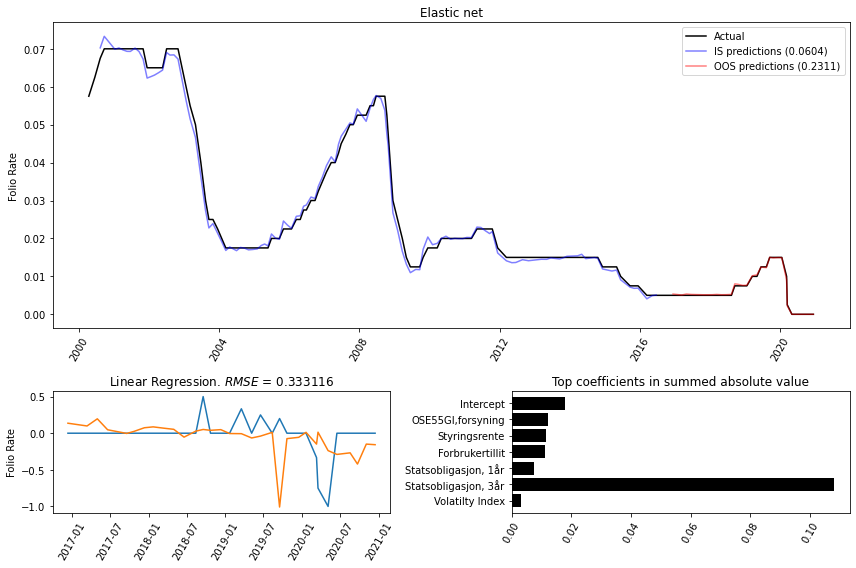

In [7]:
# === Plot Q0 prediction ===
# Prediction vs. actual
is_, oos_ = round(tscv_mse_s["tscv_mse_period_0"][0], 4), round(tscv_mse_s["tscv_mse_period_0"][1], 4)
plt.figure(figsize = (12, 8))
plt.subplot2grid((3, 2), (0, 0), colspan = 2, rowspan = 2)
plt.plot(plotting.iloc[:, 0], color = "black", label = "Actual")
plt.plot(plotting.loc[:, "y_is_pred_0"], color = "blue", alpha = 0.5, label = "IS predictions ({})".format(is_))
plt.plot(plotting.loc[:, "y_oos_pred_0"], color = "red", alpha = 0.5, label = "OOS predictions ({})".format(oos_))
plt.title(r"Elastic net")
plt.ylabel("Folio Rate")
plt.legend()
plt.xticks(rotation=60);

# Linear regression
plot_2 = pd.concat([y_test.iloc[:, 0].reset_index(drop = True), pd.Series(pred_reg)], axis = 1)
plot_2.set_index(y_test.iloc[:, 0].index, inplace = True)
plt.subplot2grid((3, 2), (2, 0), colspan = 1, rowspan = 1)
plt.plot(plot_2)
plt.title(r"Linear Regression. $RMSE$ = " + str(round(mse_reg, 6)))
plt.ylabel("Folio Rate")
plt.xticks(rotation=60);

plt.subplot2grid((3, 2), (2, 1), colspan = 1, rowspan = 1)
x = top_ten["coefs_period_0"]
plt.barh(y = list(x.index.values), width = x.loc[:, "value"], color = "black")
plt.xticks(rotation = 60)
plt.title("Top coefficients in summed absolute value");

plt.tight_layout()

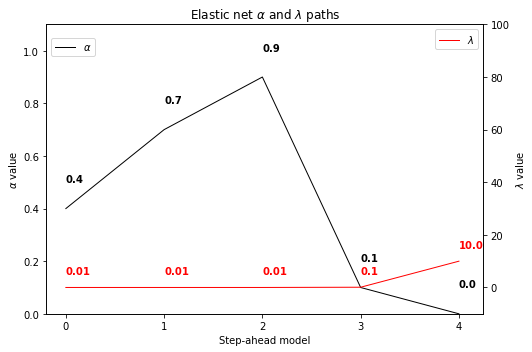

In [8]:
plt.figure(figsize = (7.5, 5))
plt.plot(alphas_, color = "black", label = r"$\alpha$", linewidth = 1)
for n, i in enumerate(alphas_):
    plt.text(x = n, y = i + 0.1, s = round(i, 2), color = "black", fontdict = {"weight":"heavy"})

plt.ylabel(r"$\alpha$ value")
plt.xlabel("Step-ahead model")
plt.legend(loc = (0.01, 0.89))
plt.ylim(bottom = 0, top = 1.1)
plt.xlim(right = 4.25)
plt.xticks(np.arange(5))
    
plt.twinx()

plt.plot(lambdas_, color = "red", label = r"$\lambda$", linewidth = 1)
for n, i in enumerate(lambdas_):
    plt.text(x = n, y = i + 5, s = round(i, 2), color = "red", fontdict = {"weight":"heavy"})

plt.ylabel(r"$\lambda$ value")
plt.xlabel("Step-ahead model")
plt.title(r"Elastic net $\alpha$ and $\lambda$ paths")
plt.legend()
plt.ylim(bottom = -10, top = 100)
plt.xlim(right = 4.25)
plt.xticks(np.arange(5))
plt.tight_layout()

#plt.savefig("./LaTeX/master_thesis/enpath.pgf")

#### Create plot of top ten coeffiecents for nowcasting, t = 1, and t = 4

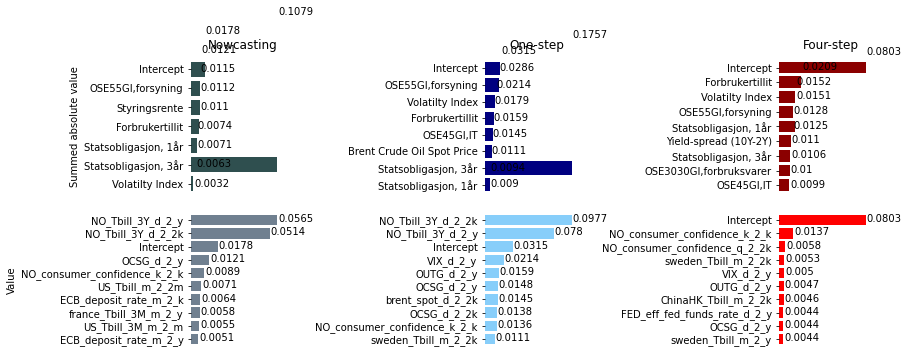

In [9]:
# === Top ten nowcasting coefficients aggregated ===
x = top_ten["coefs_period_0"]
x_ = x[x != 0].dropna()

# Replace index to accomodate plot constraints
replace_idx = list()

for n, col_name in enumerate(x_.index):
    split_ampersand = col_name.split("&")
    add_slash = "\\&".join(split_ampersand)
    replace_idx.append(add_slash)
    
x_.index = replace_idx

# Plotting
plt.figure(figsize = (12.5, 5))
plt.subplot2grid(shape = (2, 3), loc = (0, 0))
plt.barh(y = x_.index, width = x_.loc[:, "value"], color = "darkslategrey")
plt.xticks(rotation = 60)
plt.title("Nowcasting")
for i, entry in enumerate(x_.loc[:, "value"]):
    plt.text(x = entry + x_.max() * 0.01, y = i - 0.15, s = round(entry, 4))

plt.xlim(right = x_.max().value + x_.max().value * 0.2)
plt.xticks([])
plt.ylabel("Summed absolute value")
plt.box(on = False)

# === Top ten t = 1 coefficients aggregated ===
plt.subplot2grid(shape = (2, 3), loc = (0, 1))
x = top_ten["coefs_period_1"]
x_ = x[x != 0].dropna()

# Replace index to accomodate plot constraint
replace_idx = list()

for n, col_name in enumerate(x_.index):
    split_ampersand = col_name.split("&")
    add_slash = "\\&".join(split_ampersand)
    replace_idx.append(add_slash)
    
x_.index = replace_idx

# Plotting
plt.barh(y = x_.index, width = x_.loc[:, "value"], color = "navy")
plt.xticks(rotation = 60)
plt.title("One-step")
for i, entry in enumerate(x_.loc[:, "value"]):
    plt.text(x = entry + x_.max() * 0.01, y = i - 0.15, s = round(entry, 4))

plt.xlim(right = x_.max().value + x_.max().value * 0.2)
plt.xticks([])
plt.box(on = False)

# === Top ten t = 4 coefficients aggregated ===
plt.subplot2grid(shape = (2, 3), loc = (0, 2))
x = top_ten["coefs_period_4"]
x_ = x[x != 0].dropna()
replace_idx = list()

# Replace index to accomodate plot constraint
for n, col_name in enumerate(x_.index):
    split_ampersand = col_name.split("&")
    add_slash = "\\&".join(split_ampersand)
    replace_idx.append(add_slash)
    
x_.index = replace_idx

# plotting
plt.barh(y = x_.index, width = x_.loc[:, "value"], color = "darkred")
plt.xticks(rotation = 60)
plt.title("Four-step")
for i, entry in enumerate(x_.loc[:, "value"]):
    plt.text(x = entry + x_.max() * 0.01, y = i - 0.15, s = round(entry, 4))

plt.xlim(right = x_.max().value + x_.max().value * 0.2)
plt.xticks([])
plt.box(on = False)

# === Top ten nowcasting coefficients ===
plt.subplot2grid(shape = (2, 3), loc = (1, 0))
x = top_ten_total["coefs_period_0"]
x_ = x[x != 0].dropna()

# Plotting
plt.barh(y = x_.index, width = x_.loc[:, "value"], color = "slategrey")
plt.xticks(rotation = 60)
for i, entry in enumerate(x_.loc[:, "value"]):
    plt.text(x = entry + x_.max() * 0.01, y = i - 0.15, s = round(entry, 4))

plt.xlim(right = x_.max().value + x_.max().value * 0.2)
plt.xticks([])
plt.ylabel("Value")
plt.box(on = False)

# === Top ten t = 1 coefficients ===
plt.subplot2grid(shape = (2, 3), loc = (1, 1))
x = top_ten_total["coefs_period_1"]
x_ = x[x != 0].dropna()

# Plotting
plt.barh(y = x_.index, width = x_.loc[:, "value"], color = "lightskyblue")
plt.xticks(rotation = 60)
for i, entry in enumerate(x_.loc[:, "value"]):
    plt.text(x = entry + x_.max() * 0.01, y = i - 0.15, s = round(entry, 4))

plt.xlim(right = x_.max().value + x_.max().value * 0.2)
plt.xticks([])
plt.box(on = False)

# === Top ten t = 4 coefficients ===
plt.subplot2grid(shape = (2, 3), loc = (1, 2))
x = top_ten_total["coefs_period_4"]
x_ = x[x != 0].dropna()

# Plotting
plt.barh(y = x_.index, width = x_.loc[:, "value"], color = "red")
plt.xticks(rotation = 60)
for i, entry in enumerate(x_.loc[:, "value"]):
    plt.text(x = entry + x_.max() * 0.01, y = i - 0.15, s = round(entry, 4))

plt.xlim(right = x_.max().value + x_.max().value * 0.2)
plt.xticks([])
plt.box(on = False)

plt.tight_layout()

#plt.savefig("./LaTeX/master_thesis/elastic.pgf")

#### Tuning split hyperparameter

#### Export for results

In [10]:
y_oos = (1 + tscv_oos).multiply(pub_dates.shift(1).loc[tscv_oos.index].values, axis = 0).dropna()

for n, i in enumerate(y_oos.columns):
    if i == "y_oos_pred_0":
        pass
    else:
        y_oos.loc[-n:, i] = np.nan

#y_oos.to_excel("./Machine Learning Algorithms/Comparison/datasets/elastic_net_predictions_test.xlsx")

<ipython-input-10-0f1f45b40286>:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  y_oos.loc[-n:, i] = np.nan
